In [1]:
from qft_qpe_qdrift import *
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

In [2]:
# Example usage
num_qubits = 3  # Number of system qubits
num_terms = 5   # Number of terms in the Hamiltonian
num_ancilla = 3 # Number of ancilla qubits for QPE
# Generate a random Hamiltonian
hamiltonian_terms = generate_random_hamiltonian(num_qubits, num_terms)

# Calculate the smallest eigenvalue and corresponding eigenstate
smallest_eigenvalue, smallest_eigenstate = calculate_smallest_eigenstate(hamiltonian_terms)

quantum_circuits_to_simulate = []
for time in [ 0.1, 1, 100]:
    # Run qDRIFT-based QPE
    qc = qdrift_qpe(hamiltonian_terms, time, smallest_eigenstate, num_qubits, num_ancilla)
    quantum_circuits_to_simulate.append((qc, time))

# Visualize the circuit
print("Quantum Circuit:")
qc.draw("mpl", initial_state=True)

NameError: name 'generate_random_hamiltonian' is not defined

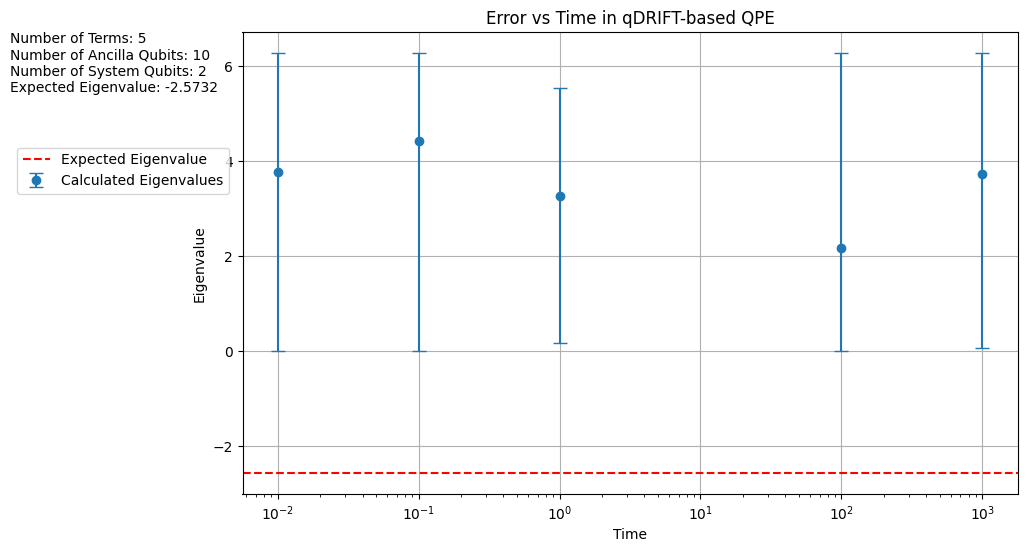

In [4]:


# Function to simulate the circuit and calculate the estimated phase and error
def simulate_circuit(qc, time, smallest_eigenvalue, num_ancilla, shots=1024):
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(transpile(qc, backend), shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Calculate the estimated phase and error
    estimated_phases = [int(key, 2) for key in counts.keys()]
    estimated_eigenvalues = [2 * np.pi * phase / (2**num_ancilla) for phase in estimated_phases]
    errors = [abs(eigenvalue - smallest_eigenvalue) for eigenvalue in estimated_eigenvalues]
    
    # Calculate the mean and standard deviation of the estimated eigenvalues
    mean_eigenvalue = np.mean(estimated_eigenvalues)
    std_eigenvalue = np.std(estimated_eigenvalues)
    
    # Calculate the most extreme values for error bars
    min_eigenvalue = min(estimated_eigenvalues)
    max_eigenvalue = max(estimated_eigenvalues)
    
    return mean_eigenvalue, std_eigenvalue, min_eigenvalue, max_eigenvalue, errors

# Function to generate the scatter plot
def plot_error_vs_time(times, mean_eigenvalues, std_eigenvalues, min_eigenvalues, max_eigenvalues, smallest_eigenvalue, num_terms, num_ancilla, num_qubits):
    plt.figure(figsize=(10, 6))
    
    # Plot the expected eigenvalue as a dotted line
    plt.axhline(y=smallest_eigenvalue, color='r', linestyle='--', label='Expected Eigenvalue')
    
    # Plot the calculated eigenvalues with error bars
    plt.errorbar(times, mean_eigenvalues, yerr=[np.array(mean_eigenvalues) - np.array(min_eigenvalues), np.array(max_eigenvalues) - np.array(mean_eigenvalues)],
                 fmt='o', capsize=5, label='Calculated Eigenvalues')
    
    # Add a box with simulation information
    info_text = (
        f"Number of Terms: {num_terms}\n"
        f"Number of Ancilla Qubits: {num_ancilla}\n"
        f"Number of System Qubits: {num_qubits}\n"
        f"Expected Eigenvalue: {smallest_eigenvalue:.4f}"
    )
    plt.text(-0.3, 1, info_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Eigenvalue')
    plt.title('Error vs Time in qDRIFT-based QPE')
    # add legend to the left of the plot
    plt.legend(loc='center left', bbox_to_anchor=(-0.3, 0.7))
    plt.grid(True)
    plt.xscale('log')  # Use log scale for time
    plt.show()


# Main code to gather data and generate the plot
num_qubits = 2  # Number of system qubits
num_terms = 5   # Number of terms in the Hamiltonian
num_ancilla = 10 # Number of ancilla qubits for QPE

# Generate a random Hamiltonian
hamiltonian_terms = generate_random_hamiltonian(num_qubits, num_terms)

# Calculate the smallest eigenvalue and corresponding eigenstate
smallest_eigenvalue, smallest_eigenstate = calculate_smallest_eigenstate(hamiltonian_terms)

# Gather data for different time values
times = [0.01, 0.1, 1, 100, 1000]
mean_eigenvalues = []
std_eigenvalues = []
min_eigenvalues = []
max_eigenvalues = []

for time in times:
    # Run qDRIFT-based QPE
    qc = qdrift_qpe(hamiltonian_terms, time, smallest_eigenstate, num_qubits, num_ancilla)
    
    # Simulate the circuit and calculate the results
    mean_eigenvalue, std_eigenvalue, min_eigenvalue, max_eigenvalue, _ = simulate_circuit(qc, time, smallest_eigenvalue, num_ancilla)
    
    # Store the results
    mean_eigenvalues.append(mean_eigenvalue)
    std_eigenvalues.append(std_eigenvalue)
    min_eigenvalues.append(min_eigenvalue)
    max_eigenvalues.append(max_eigenvalue)

# Generate the scatter plot
plot_error_vs_time(times, mean_eigenvalues, std_eigenvalues, min_eigenvalues, max_eigenvalues, smallest_eigenvalue, num_terms, num_ancilla, num_qubits)

In [10]:

import seaborn as sns
import pandas as pd
def calculate_ancilla_qubits(epsilon, delta):
    """
    Calculate the number of ancilla qubits required for QPE.
    
    Args:
        epsilon (float): Desired precision (error tolerance).
        delta (float): Desired success probability.
    
    Returns:
        int: Number of ancilla qubits.
    """
    m = np.ceil(np.log2(1 / epsilon) + np.ceil(np.log2(1 / (1 - delta))))
    return int(m)

# Function to simulate the circuit and calculate the estimated phase and error
def simulate_circuit_v2(qc, time, num_ancilla, shots=1024):
    """
    Simulate the QPE circuit and calculate the estimated eigenvalues.
    
    Args:
        qc (QuantumCircuit): The QPE circuit.
        time (float): Simulation time.
        num_ancilla (int): Number of ancilla qubits.
        shots (int): Number of shots for the simulation.
    
    Returns:
        list: List of estimated eigenvalues.
    """
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(transpile(qc, backend), shots=shots)
    result = job.result()
    counts = result.get_counts()
    print(f"Counts for time {time}: {counts}")
    #plot histogram
    plt.bar(counts.keys(), counts.values())
    # x-axis labels should be diagonal for betteer readability
    plt.xticks(rotation=45)
    plt.show()
    
    # Calculate the estimated phase and eigenvalue
    estimated_phases = [int(key, 2) for key in counts.keys()]
    top_5_measurements = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5])
    top_5_estimated_phases = [int(key, 2) for key in top_5_measurements.keys()]
    top_5_estimated_eigenvalues = [2 * np.pi * phase / (2**num_ancilla) for phase in top_5_estimated_phases]
    # remove all eigenvalues that are more than one standard deviation away from the mean
    # estimated_eigenvalues = [eigenvalue for eigenvalue in estimated_eigenvalues if abs(eigenvalue - np.mean(estimated_eigenvalues)) <= np.std(estimated_eigenvalues)]
    
    return top_5_estimated_eigenvalues

def plot_eigenvalues_vs_time(simulation_times, all_estimated_eigenvalues, true_eigenvalues, num_terms, num_ancilla, num_qubits):
    """
    Plot the true eigenvalues as horizontal dotted lines and overlay the estimated eigenvalues as points.
    
    Args:
        simulation_times (list): List of simulation times.
        all_estimated_eigenvalues (list): List of lists of estimated eigenvalues for each simulation time.
        true_eigenvalues (list): List of true eigenvalues.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot true eigenvalues as horizontal dotted lines
    for i, eigenvalue in enumerate(true_eigenvalues):
        plt.axhline(y=eigenvalue, color=f'C{i}', linestyle='--', label=f'True Eigenvalue {i+1}')
    
    # Plot estimated eigenvalues as points
    dfs = []
    for t, results in zip(simulation_times, all_estimated_eigenvalues):
        curr_df = pd.DataFrame({"Time": [t]*len(results), "Estimated Eigenvalue": results})
        dfs.append(curr_df)
    df = pd.concat(dfs)
    sns.stripplot(data=df, x="Time", y="Estimated Eigenvalue", jitter=0.002, palette='tab10', alpha=0.7)
        
    # Add a box with simulation information
    info_text = (
        f"Number of Terms: {num_terms}\n"
        f"Number of Ancilla Qubits: {num_ancilla}\n"
        f"Number of System Qubits: {num_qubits}\n"
    )
    plt.text(-0.3, 1, info_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    # Customize the plot
    plt.xlabel('Simulation Time')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues vs Simulation Time')
    plt.legend()
    plt.grid(True)
    plt.show()


Number of Ancilla Qubits: 12


  0%|          | 0/6 [00:00<?, ?it/s]

Counts for time 0.01: {'111111101101': 8, '111111110101': 88, '111111111101': 20, '111110010101': 1, '110101000000': 1, '111111111000': 53, '111100111100': 1, '111111110000': 23, '111110110101': 2, '111111111001': 12, '111111101000': 1, '111111111010': 2, '000000010000': 1, '111111000000': 4, '111111110011': 52, '111110111100': 2, '011111110111': 1, '111110111111': 2, '111111100011': 1, '000000000011': 10, '001010111100': 1, '000000101100': 1, '000000000001': 13, '000001010100': 1, '111110111110': 2, '111111100000': 3, '111111110100': 30, '000000011110': 1, '111111111110': 2, '000000010100': 1, '111111110110': 23, '111111111111': 7, '111111101110': 12, '111111011000': 1, '111111000001': 2, '111111110010': 6, '111101110101': 2, '000000000000': 22, '111111010010': 1, '111110100000': 1, '000000110101': 1, '000000000010': 2, '111111111100': 8, '111111001100': 1, '111111101001': 1, '000100010000': 1, '111101000000': 2, '111110111101': 2, '111111110111': 12, '111111001001': 1, '111111101100'

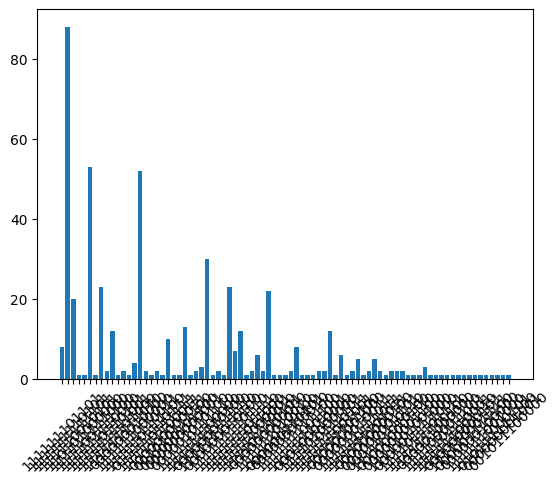

 17%|█▋        | 1/6 [04:32<22:40, 272.03s/it]

Counts for time 0.1: {'111101001010': 3, '000000000010': 2, '111111000111': 2, '010001111110': 1, '111100010001': 1, '000110110011': 1, '001000011110': 2, '111111101000': 3, '010011011010': 1, '111110111110': 1, '110100011011': 1, '000010111110': 1, '000101110001': 1, '000011001000': 2, '010011110101': 1, '110100000010': 2, '000001101011': 1, '000100110000': 1, '000101011111': 1, '000000010001': 2, '000010110111': 1, '000101111100': 1, '110111001111': 1, '101000010001': 1, '000011111111': 2, '000010001000': 3, '111111000001': 1, '111000000110': 1, '111100100111': 1, '000010001010': 2, '110011010010': 1, '111101010100': 1, '000011011111': 3, '010010000100': 1, '000000110111': 1, '000000001010': 4, '000011101101': 3, '111000100010': 1, '110100010111': 1, '110010111010': 1, '111000001010': 1, '100000001101': 2, '111110010001': 1, '000010110100': 1, '000000100111': 1, '111011110000': 1, '000000000111': 1, '100011100100': 1, '010000100001': 1, '110100010010': 3, '000010000011': 1, '00001011

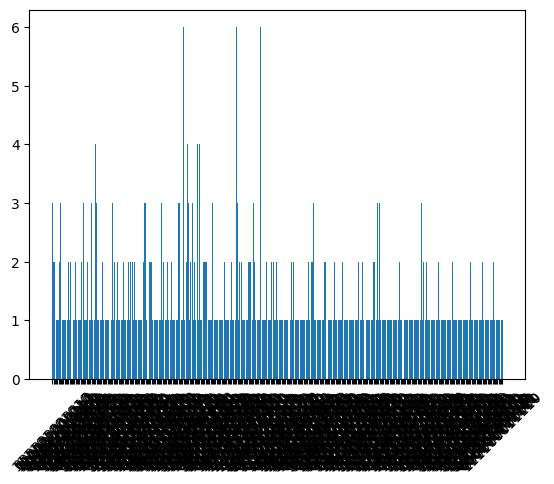

 33%|███▎      | 2/6 [09:16<18:37, 279.32s/it]

Counts for time 1: {'000101110010': 1, '000001010011': 10, '111111111111': 1, '000000010111': 3, '000011110010': 1, '000000110010': 3, '111000000110': 2, '111110011111': 1, '000000011110': 1, '111110011001': 2, '100101111100': 1, '000001001001': 4, '111110100010': 1, '110111110101': 1, '111000011001': 1, '110101111100': 1, '010110100111': 1, '000110001000': 2, '000010000011': 5, '000001011100': 1, '000101111011': 1, '001000100110': 2, '000000100011': 13, '000000111101': 2, '110110000111': 1, '011110100011': 1, '000001001110': 4, '000000111110': 1, '001000001000': 2, '000000100010': 3, '000001001010': 1, '000000100111': 2, '110110000011': 1, '000001000010': 2, '000000110011': 3, '000110010000': 3, '110110010011': 1, '110101111010': 2, '111111101011': 1, '000010000001': 4, '111101100011': 2, '000010001000': 1, '000110000011': 3, '111110111010': 2, '000010010101': 2, '000000100100': 6, '000010100010': 3, '111111011001': 2, '001000110010': 1, '000011000010': 1, '000000111011': 3, '00000010

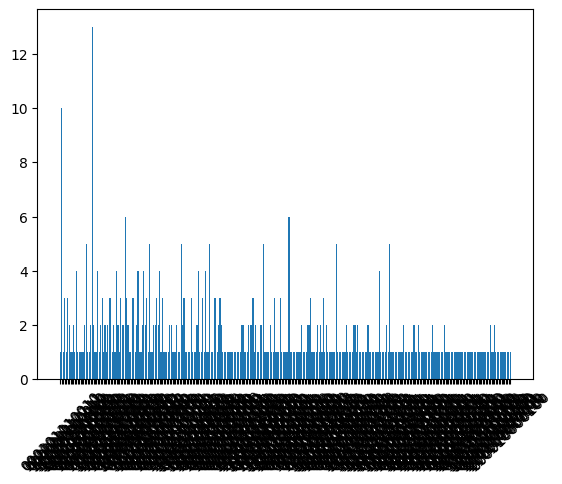

 50%|█████     | 3/6 [13:50<13:51, 277.09s/it]

Counts for time 10: {'011110011001': 1, '100001110100': 3, '011111100100': 5, '100010000000': 1, '011111011100': 23, '011111001011': 10, '011110001001': 2, '111111010100': 1, '011010011100': 1, '011011100111': 1, '011111011110': 21, '011111101010': 9, '111111001111': 1, '011101100000': 1, '011111011111': 9, '011110001000': 14, '011110011000': 1, '001001011110': 1, '011101110110': 10, '011101101110': 4, '101011110010': 1, '011111100111': 16, '101010001011': 1, '011101001000': 1, '011111101000': 8, '011111110010': 4, '011101011110': 3, '011111100101': 3, '011111000110': 3, '011101101001': 1, '011111011001': 3, '100000110011': 3, '011110001110': 1, '011101110000': 1, '011111110101': 3, '100001110111': 1, '011101110100': 11, '101011110110': 1, '011110001011': 5, '100000001010': 2, '100001100111': 1, '011100000010': 1, '011111100001': 6, '111101110010': 1, '111010011100': 1, '011101101000': 2, '011111000111': 4, '100000001000': 9, '011101100110': 4, '011111001001': 7, '011101101011': 1, '01

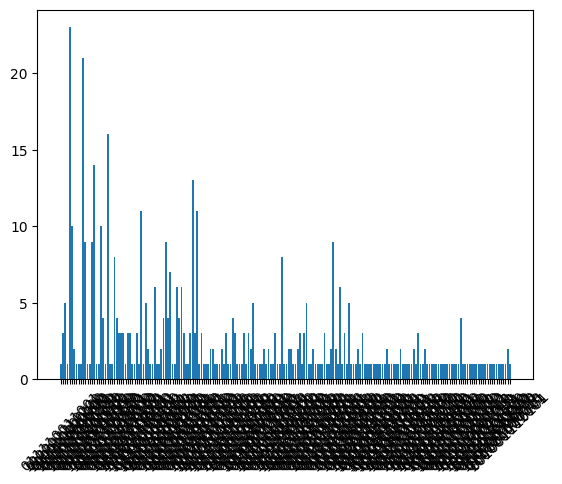

 67%|██████▋   | 4/6 [18:24<09:11, 275.55s/it]

Counts for time 100: {'000101101001': 1, '000001010111': 1, '101101110001': 2, '011010110110': 2, '101100101011': 1, '010111110101': 1, '100000001011': 2, '000100010001': 1, '011011101011': 1, '010000101110': 1, '011011010001': 1, '111011110001': 1, '110101010001': 1, '100001001011': 1, '100110101101': 1, '110110010101': 1, '101101001011': 3, '100010100011': 1, '101011011001': 1, '011100011101': 2, '111101011101': 1, '111011110010': 1, '100001110000': 1, '000000111011': 1, '100111101100': 1, '000101001000': 1, '110110000001': 1, '001010110101': 1, '010111001001': 1, '110100010111': 1, '111111001000': 1, '110111001111': 1, '101010101010': 1, '101100110100': 1, '011111111110': 1, '101110101001': 1, '010100011111': 1, '010101110111': 1, '011000101000': 1, '001010101110': 1, '001111111011': 2, '101101001100': 2, '010110101100': 2, '100110001101': 1, '011101011001': 1, '100010101000': 1, '010110011010': 1, '101111001000': 1, '000001101100': 1, '110101111001': 1, '101110110000': 2, '10101000

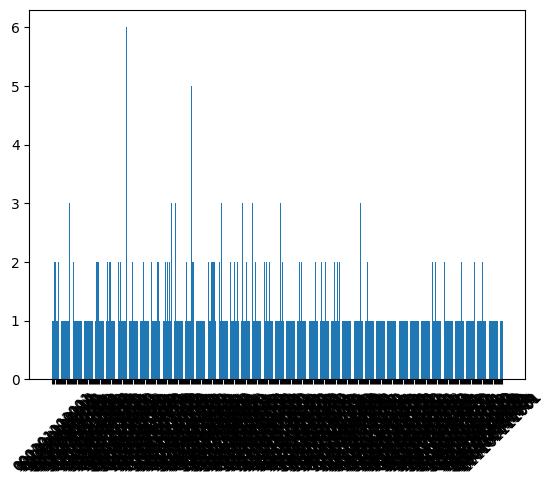

 83%|████████▎ | 5/6 [23:00<04:35, 275.71s/it]

Counts for time 1000: {'010010001011': 2, '110001000001': 3, '111011110001': 1, '100111100000': 1, '110000110101': 1, '010001011101': 2, '010001000011': 1, '000100010001': 1, '110010001000': 1, '100101010101': 2, '000011010101': 1, '010101101100': 1, '101111001100': 3, '110000000111': 2, '100011111011': 1, '001111100100': 1, '111010001001': 1, '111100001101': 1, '000111001011': 1, '101101010000': 1, '000011000010': 1, '100111101100': 2, '110001000010': 1, '101000111010': 1, '100111001001': 3, '010011110011': 1, '101111010001': 1, '110010000101': 1, '000111100000': 1, '110111101000': 1, '110000101011': 1, '000100001111': 1, '110000110001': 1, '101110001110': 3, '100111000111': 3, '101000000110': 1, '111001011010': 1, '101111011110': 2, '011100001110': 1, '111001100101': 1, '110111011011': 1, '000011011101': 3, '010001101000': 1, '001110010110': 1, '111010101101': 1, '110000111101': 1, '001111001101': 3, '101110110010': 1, '100100101110': 1, '010101100011': 1, '101111000011': 1, '1101010

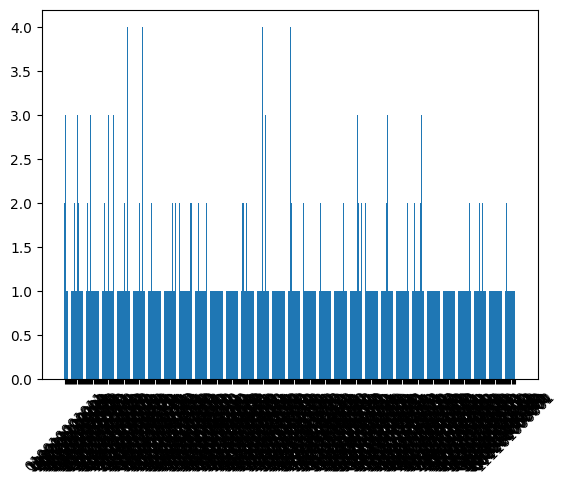

100%|██████████| 6/6 [27:44<00:00, 277.34s/it]
C:\Users\rodcs\AppData\Local\Temp\ipykernel_2416\3087176231.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Time", y="Estimated Eigenvalue", jitter=0.002, palette='tab10', alpha=0.7)


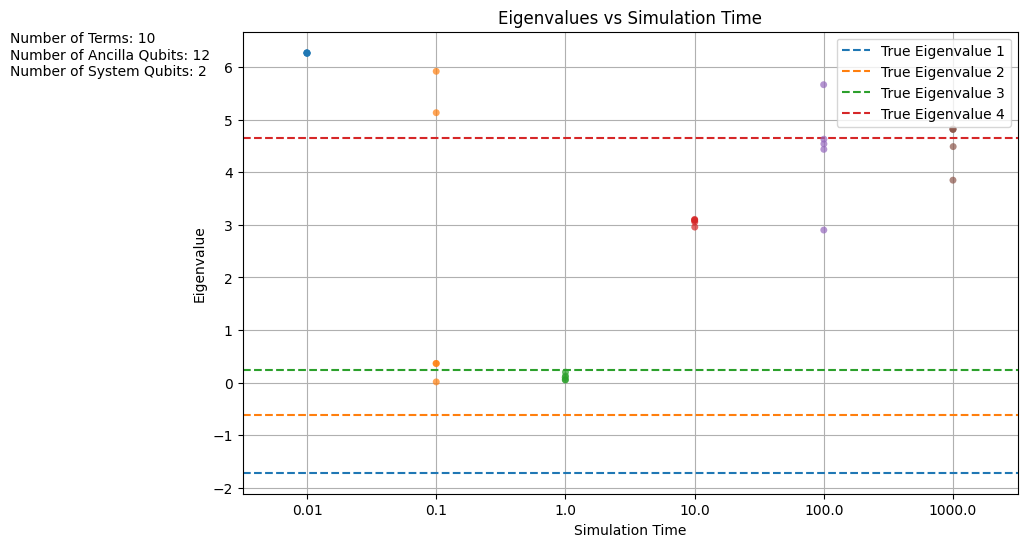

In [12]:
from tqdm import tqdm

num_qubits = 2
num_terms = 10
epsilon = 1e-2
delta = 0.95

# Generate a random Hamiltonian
hamiltonian_terms = generate_random_hamiltonian(num_qubits, num_terms)

# Calculate the smallest eigenvalue and corresponding eigenstate
smallest_eigenvalue, smallest_eigenstate= calculate_smallest_eigenstate(hamiltonian_terms)
H = sum(coeff * op.to_matrix() for coeff, op in hamiltonian_terms)
all_eigenvalues = np.linalg.eigvalsh(H)

# Calculate the number of ancilla qubits
num_ancilla = calculate_ancilla_qubits(epsilon, delta)
print(f"Number of Ancilla Qubits: {num_ancilla}")

# Run QPE for different simulation times
simulation_times = [0.01, 0.1, 1, 10, 100, 1000]
all_estimated_eigenvalues = []

for time in tqdm(simulation_times):

    qc = qdrift_qpe(hamiltonian_terms, time, smallest_eigenstate, num_qubits, num_ancilla)
    estimated_eigenvalues = simulate_circuit_v2(qc, time, num_ancilla, shots=500)
    all_estimated_eigenvalues.append(estimated_eigenvalues)

# Plot the results
true_eigenvalues = all_eigenvalues  # Replace with all eigenvalues for the full Hamiltonian
plot_eigenvalues_vs_time(simulation_times, all_estimated_eigenvalues, true_eigenvalues, num_terms=num_terms, num_ancilla=num_ancilla, num_qubits=num_qubits)


